# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss_with_reg, loss)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [22]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.257349, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.156543, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284460, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.133622, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.237598, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.009313, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.123666, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.226096, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.098399, Train accuracy: 0.202667, val accuracy: 0.210000
Loss: 2.086190, Train accuracy: 0.227778, val accuracy: 0.237000
Loss: 2.089915, Train accuracy: 0.250778, val accuracy: 0.251000
Loss: 2.184890, Train accuracy: 0.264889, val accuracy: 0.265000
Loss: 2.132385, Train accuracy: 0.286889, val accuracy: 0.285000
Loss: 2.004860, Train accuracy: 0.321778, val accuracy: 0.328000
Loss: 1.948629, Train accuracy: 0.359778, val accuracy: 0.364000
Loss: 1.650998, Train acc

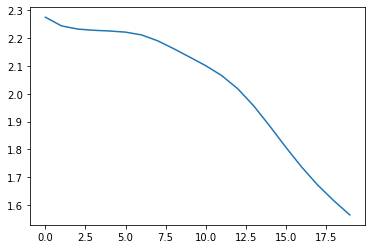

In [23]:
plt.plot(loss_history)

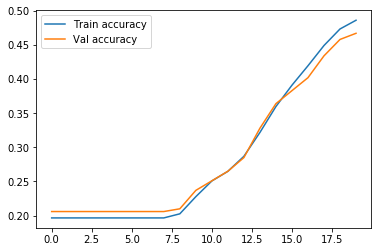

In [32]:
plt.plot(train_history, label='Train accuracy')
plt.plot(val_history, label='Val accuracy')
plt.legend()

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [34]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.282786, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234582, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.145585, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.196805, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287513, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248047, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.186539, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.912230, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256953, Train accuracy: 0.200556, val accuracy: 0.210000
Loss: 1.962076, Train accuracy: 0.222889, val accuracy: 0.232000
Loss: 1.949703, Train accuracy: 0.247222, val accuracy: 0.247000
Loss: 2.092175, Train accuracy: 0.263444, val accuracy: 0.264000
Loss: 1.871600, Train accuracy: 0.275111, val accuracy: 0.277000
Loss: 1.807875, Train accuracy: 0.289778, val accuracy: 0.296000
Loss: 1.756844, Train accuracy: 0.318333, val accuracy: 0.325000
Loss: 1.824883, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [40]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.477746, Train accuracy: 0.207111, val accuracy: 0.218000
Loss: 1.670014, Train accuracy: 0.377333, val accuracy: 0.381000
Loss: 1.544592, Train accuracy: 0.542556, val accuracy: 0.545000
Loss: 1.194426, Train accuracy: 0.619333, val accuracy: 0.606000
Loss: 1.423355, Train accuracy: 0.669667, val accuracy: 0.641000
Loss: 1.276991, Train accuracy: 0.686889, val accuracy: 0.669000
Loss: 1.089824, Train accuracy: 0.732444, val accuracy: 0.689000
Loss: 0.956152, Train accuracy: 0.745333, val accuracy: 0.704000
Loss: 0.683732, Train accuracy: 0.736667, val accuracy: 0.702000
Loss: 0.457056, Train accuracy: 0.760444, val accuracy: 0.704000
Loss: 0.352953, Train accuracy: 0.785333, val accuracy: 0.716000
Loss: 0.617933, Train accuracy: 0.788889, val accuracy: 0.719000
Loss: 0.984979, Train accuracy: 0.787000, val accuracy: 0.709000
Loss: 0.395877, Train accuracy: 0.812667, val accuracy: 0.717000
Loss: 0.551306, Train accuracy: 0.820222, val accuracy: 0.728000
Loss: 0.574415, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [47]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.335231, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.335398, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.295406, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.281863, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.321520, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.309492, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.258361, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.284447, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.118838, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 1.894776, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.841060, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.200363, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.900459, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.350083, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.765621, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.058465, Train acc

Loss: 1.128289, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.279278, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.353710, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.394760, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [86]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=0.33, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.330895, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.254492, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.134727, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.250895, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.747145, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.728131, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.641526, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.654881, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.000118, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.303145, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.371834, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.206700, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.251464, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.635919, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.706850, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 0.927683, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

The idea will be the following: first, we choose among large range of parameters, and then I will adjust further.

In [102]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-2, 1e-1, 0.35]
reg_strength = [1e-5, 1e-4]
learning_rate_decay = [0.9, 0.99, 0.999]
hidden_layer_size = [100, 200, 300]
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = -1
coef_to_val_accuracy = {}

loss_history = []
train_history = []
val_history = []


# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
dataset = Dataset(train_X, train_y, val_X, val_y)
for lr in learning_rates:
    for reg in reg_strength:
        for lrd in learning_rate_decay:
            for hidden_layer_s in hidden_layer_size:
                model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_s, reg = reg)
                trainer = Trainer(model,
                                  dataset,
                                  MomentumSGD(),
                                  num_epochs = num_epochs,
                                  batch_size = batch_size,
                                  learning_rate=lr,
                                  learning_rate_decay=lrd)
                print(f'Fitting: learning rate = {lr}, regularization strength = {reg}, learning rate decay = {lrd}, hidden_layer_size = {hidden_layer_s}' )

                loss_history, train_history, val_history = trainer.fit()
                coef_to_val_accuracy[(lr, reg, hidden_layer_s)] = val_history[-1]
                print(f'Resulting accuracy is {val_history[-1]}\n')
                if val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = val_history[-1]
print('best validation accuracy achieved: %f' % best_val_accuracy)

Fitting: learning rate = 0.01, regularization strength = 1e-05, learning rate decay = 0.9, hidden_layer_size = 100
Resulting accuracy is 0.639

Fitting: learning rate = 0.01, regularization strength = 1e-05, learning rate decay = 0.9, hidden_layer_size = 200


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))